# Epithelial lineage - Seurat analysis

Please, save the anndata object as follows

```
adata_count = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs, asview=False) # if adata.raw is not log
```


In [1]:
library(Seurat)
library(dplyr)
library(RColorBrewer)
library(destiny, quietly = TRUE)
library(gam)
library(harmony)
library(ggplot2)
library(pheatmap)
library(cowplot)
library(SoupX)

luz_colors = c('#c466b0', '#779eed', '#aad3f2', '#71a2c7', '#60bddb',   '#70ccbe', 
               '#7b9e99', '#91bd80', '#bdb380',  '#d4db81', '#ebd3c3',  '#dba781', 
               '#e08b8b', '#edb7b7', '#d9abb7', '#d96884', '#e64e74', '#d9a5c3', '#cc8fdb')

colors = c(luz_colors, 
           brewer.pal(n=12, name = 'Paired'), 
           brewer.pal(n=8, name = 'Set2'),
          brewer.pal(n=8, name = 'Set3'),
          brewer.pal(n=8, name = 'Accent'),
          brewer.pal(n=8, name = 'Pastel1'))


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: splines

Loading required package: foreach

Loaded gam 1.20


Loading required package: Rcpp



In [2]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS:   /home/jovyan/my-conda-envs/R_Seurat3/lib/libblas.so.3.8.0
LAPACK: /home/jovyan/my-conda-envs/R_Seurat3/lib/liblapack.so.3.8.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] splines   stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] SoupX_1.5.0        cowplot_1.1.1      pheatmap_1.0.12    ggplot2_3.3.3     
 [5] harmony_1.0        Rcpp_1.0.6         gam_1.20           foreach_1.5.1     
 [9] destiny_3.4.0      RColorBrewer_1.1-2 dplyr_1.0.5        Seurat_3.

In [3]:
markers = list( 'somatic progenitor' = c('WT1', 'NR5A1'),
                'supporting lineage' = c('WNT6', 'WIPF3', 'GATA4'),
                'coelomic epi' = c('LRRN4', 'UPK3B', 'KLK11'),
                sLGR5 = c('LGR5'),
                sPAX8 = c('PAX8', 'PLAU', 'PERP', 'NTRK2', 'SST'),
                OSE= c('LHX9', 'LHX2', 'CALB2'),
                'pre-granulosa' = c( "KITLG", 'CSRNP1', 'CYP26B1', 'FOXL2',  'OSR1', 'RSPO1', 'WNT4', 'CYP19A1',  'RDH10', 'BMP2'),
                Sertoli = c('SOX9',  'AMH', 'INHBB', 'CITED1'),
                'Fetal Leydig' = c('FDX1', 'INSL3',  'PTCH1',  'PTCH2', 'CYP17A1'),
                mesenchymal = c('DCN', 'PDGFRA', 'COL1A1'),
                gonadal_somatic = c('ARX', 'MSC'),
                ovary_stroma = c('SPRR2F', 'AKR1C1', 'DIRAS3'),
                testis_border_mesenhyme = c('IGF1', 'FGL2', 'PCSK2', 'ANGPTL1'),
                extragonadal_mesen = c('GATA2', 'NR2F1'),
                mesoneprhic_stroma = c('CRABP1', 'ALX1',  'FOXD1'),
                muscoskeletal = c('MYF5','PAX7','MYF6', 'MYLPF'),
                epithelial = c("EPCAM"),
                PGCs= c('POU5F1', 'NANOG', 'NANOS3'),
                GCs = c('DAZL', 'DDX4'),
                immunePGCs= c('PTPRC'),
                endothelial = c('PECAM1', 'VWF', 'CDH5'),
                erythroid = c("GYPC", "HBA1"),
                neural = c('ASCL1', 'ELAVL4'),
                PV = c("PDGFRB", 'ACTA2'),
                cycling = c('CDK1', 'MKI67'),
                quiescent = c('CDKN1B'),
                male = c('SRY', 'RPS4Y1','DDX3Y')       
)
unlist(markers)[ which(duplicated(unlist(markers))) ]

named character(0)

# Process with Seurat from raw

In [4]:
# Load and pre-process wth standard workflow
anndata <- ReadH5AD(file = '/nfs/team292/lg18/with_valentina/FCA-M5-annotatedCluster4Seurat.h5ad')
allgenes = rownames(anndata)
anndata

Warning message:
“Functionality for reading and writing H5AD files is being moved to SeuratDisk
For more details, please see https://github.com/mojaveazure/seurat-disk
and https://mojaveazure.github.io/seurat-disk/index.html”
Pulling expression matrices and metadata

Data is unscaled

Creating assay object

Storing X as raw and raw as counts

No variable feature expression found in h5ad file

No dimensional reduction information found

Assembling Seurat object

No nearest-neighbor graph

No additional layers found



An object of class Seurat 
28230 features across 319081 samples within 1 assay 
Active assay: RNA (28230 features, 0 variable features)

In [5]:
# # Remove CCG
# ccgs = read.csv('figures_manual_annotation/cell_cycle_genes.csv', stringsAsFactors = F)$X0
# anndata = subset(anndata, features = setdiff(allgenes, ccgs) )

In [6]:
# Add metadata
meta = read.csv('/nfs/team292/lg18/with_valentina/FCA-M5-annotatedCluster4Seurat.csv', stringsAsFactors = F)
names(meta)[1] = 'index'
anndata@meta.data$is_doublet = meta$is_doublet[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$clusters = meta$clusters_manual[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$PCW = meta$PCW[ match(rownames(anndata@meta.data), meta$index) ] %>% as.numeric(.)
anndata@meta.data$sex = meta$sex[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$TP = meta$TP[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$process = meta$process[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$individual = meta$individual[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$sample_source = meta$sample_source[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$scrublet_cluster_score = meta$scrublet_cluster_score[ match(rownames(anndata@meta.data), meta$index) ] %>% as.numeric(.)

In [7]:
table(anndata@meta.data$clusters)


               Coel Epi                Doublets             Endothelial 
                  12001                    5639                   10948 
             Epithelial               Erythroid              Germ cells 
                   9679                    7423                   11388 
                 Immune                   lowQC Mesenchymal_GATA2_NR2F1 
                   5157                   20815                   77319 
   Mesenchymal_LHX9_ARX             Metanephros                  Neural 
                  51992                    1503                    2530 
                     PV                 Sertoli       Supporting_female 
                   7440                   37796                   57451 

In [8]:
# subset datasets to contain clusters of interest and remove doublets
clusters_of_interest = c('Epithelial')
anndata = subset(anndata, cells = rownames(subset(anndata@meta.data, clusters %in% clusters_of_interest)))
# anndata = subset(anndata, cells = rownames(subset(anndata@meta.data, is_doublet == 'False' )))
anndata
all(clusters_of_interest %in% anndata@meta.data$clusters)
table(anndata@meta.data$clusters)

An object of class Seurat 
28230 features across 9679 samples within 1 assay 
Active assay: RNA (28230 features, 0 variable features)

[1] TRUE


Epithelial 
      9679 

In [11]:
# Remove lowQC and doublets from previous round
meta_sup = read.csv('/nfs/team292/lg18/with_valentina/epithelial_annotation_doublets.csv', stringsAsFactors = F)

# Add metadata
anndata@meta.data$clusters_previous = 'new'
anndata@meta.data$clusters_previous[ rownames(anndata@meta.data) %in% meta_sup$X ] = 
meta_sup$annotated_clusters[ match(rownames(anndata@meta.data)[rownames(anndata@meta.data) %in% meta_sup$X], meta_sup$X) ]

table(anndata@meta.data$clusters_previous)


        doublet_I        doublet_II       Epi_cycling         Epi_GATA3 
             1097               299               963               978 
Epi_MesoDuct_CUBN      Epi_MullDuct      Epi_WolfDuct 
              682              4631              1029 

In [12]:
# subset datasets to contain clusters of interest and remove doublets
clusters2remove = c('doublet_I', 'doublet_II', 'lowQC', 'Epi_cycling')
anndata = subset(anndata, cells = rownames(subset(anndata@meta.data, ! clusters_previous %in% clusters2remove)))
anndata = subset(anndata, cells = rownames(subset(anndata@meta.data, is_doublet == 'False' )))
anndata
table(anndata@meta.data$clusters_previous)

An object of class Seurat 
28230 features across 7258 samples within 1 assay 
Active assay: RNA (28230 features, 0 variable features)


        Epi_GATA3 Epi_MesoDuct_CUBN      Epi_MullDuct      Epi_WolfDuct 
              960               681              4605              1012 

In [14]:
# basic gene/cell filtering
message('Removing ', sum(anndata@meta.data$nCount_RNA < 500), ' cells with less than 500 nCount_RNA' )
anndata <- subset(anndata, cells = colnames(anndata)[ anndata@meta.data$nCount_RNA >= 500 ] )
                    
gene_counts = apply(anndata@assays$RNA@counts, 1, function(xx) sum(xx>0) )
message('Removing ', sum(gene_counts <= 3), ' genes' )
anndata <- subset(anndata, features = names(gene_counts)[ gene_counts > 3 ] )

Removing 0 cells with less than 500 nCount_RNA

Removing 6816 genes



In [15]:
# basic preprocessing
anndata <- NormalizeData(anndata, normalization.method = "LogNormalize", scale.factor = 10000)
anndata <- FindVariableFeatures(anndata)
anndata <- ScaleData(anndata, features = rownames(anndata))
anndata

Centering and scaling data matrix



An object of class Seurat 
21414 features across 7258 samples within 1 assay 
Active assay: RNA (21414 features, 2000 variable features)

Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms”
Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 3 features requested have not been scaled (running reduction without them): MLF1IP, FAM64A, HN1”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
PC_ 1 
Positive:  RAD51, G2E3, E2F8, PSRC1, KIF11, CDC25C, CENPA, KIF2C, CDCA3, HJURP 
	   CKAP2, ANLN, CDCA2, CKAP2L, AURKA, GAS2L3, CCNE2, NCAPD2, ECT2, DLGAP5 
	   KIF23, BUB1, CDCA8, UBR7, EXO1, RANGAP1, NUF2, TTK, CKAP5, NDC80 
Negative:  GINS2, TYMS, MCM5, MCM6, UHRF1, CDCA7, HELLS, MCM2, NASP, PCNA 
	   MCM4, DTL, NUSAP1, RAD51AP1, CDK1, CDC6, UNG, RFC2, CLSPN, SLBP 
	   FEN1, CDC45, RRM1, CKS2, HMGB2,

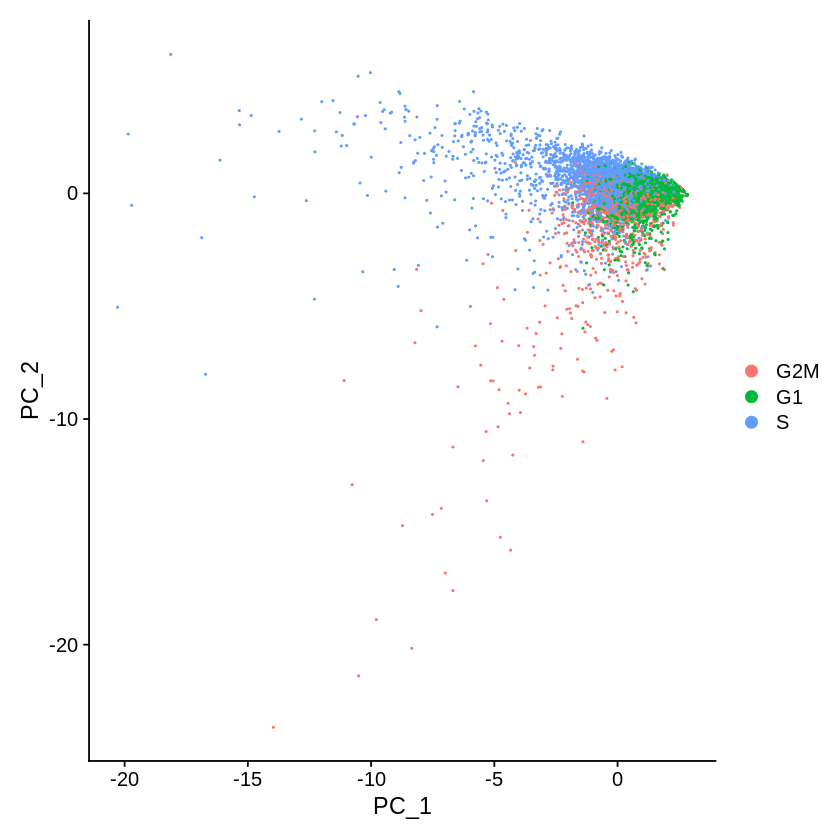

In [16]:
# check cell cycle effect
anndata <- CellCycleScoring(anndata, s.features = cc.genes$s.genes, g2m.features = cc.genes$g2m.genes, set.ident = TRUE)
anndata <- RunPCA(anndata, features = c(cc.genes$s.genes, cc.genes$g2m.genes))
DimPlot(anndata, reduction = 'pca')

In [17]:
anndataO = anndata
# Regress out cell cycle - NOTE: subset the dataset to speed up process
anndata = subset(anndata, features = VariableFeatures(object = anndata))
# anndata <- ScaleData(anndata, vars.to.regress = c("S.Score", "G2M.Score"), features = rownames(anndata))

PC_ 1 
Positive:  MSLN, PNOC, ERP27, SOX17, KRT7, CMTM6, BCAT1, PART1, ANXA1, LGALS3 
	   SLC34A2, SCGB2A1, DAPL1, DOK5, EHF, FILIP1, RNASE1, WFDC2, KLK11, MUC1 
	   MYC, PKP2, ADAM28, CAPS, SLPI, ESR1, FOLR1, C2orf88, UPK3B, SCGB1D2 
Negative:  APOE, FXYD2, GPC3, PDZK1, TMEM176A, DAB2, BHMT, SERPINF1, MPC2, TMEM176B 
	   SMIM24, CYB5A, AFP, CCDC198, VCAN, SLC39A5, FTL, LGALS2, SLC3A1, ITM2C 
	   FLRT3, TMEM37, DBI, UGT3A1, GATM, GPX3, KCNJ15, ABCC6, HGD, CDHR5 
PC_ 2 
Positive:  AFP, PPP1R16A, HAO2, GSN, AGT, SLC34A1, CUBN, PRODH2, AMN, APOA1 
	   APOM, FTCD, FAM151A, DPYS, SLC22A6, FABP1, APOC3, APOB, CDHR5, SERPINA1 
	   AGXT2, DDC, TINAG, SLC51B, GLYATL1, VTN, MT1G, LINC01781, SLC7A7, SLC9A3R1 
Negative:  MAL, TUBB2B, GATA3, SOX4, TFAP2A, HES1, SCIN, DNER, TUBA1A, STMN1 
	   UCHL1, TSC22D1, HOXD9, SCUBE3, LIMCH1, TBX3, TOX3, TFCP2L1, HOXB9, CLDN6 
	   AC004540.2, CTHRC1, PTBP3, ACTB, GSTM3, HOXA10, LINC01116, COL1A2, BASP1, RDH10 
PC_ 3 
Positive:  TMEM52B, DEFB1, HOXB-AS3, VAV3, T

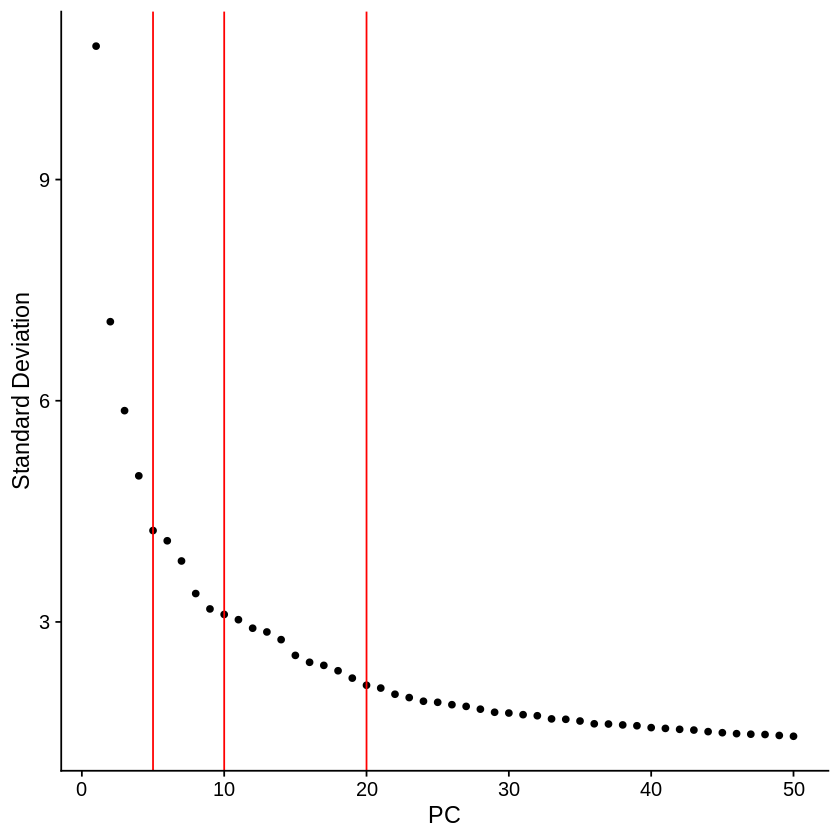

In [18]:
# Compute PCA
anndata <- RunPCA(anndata, features = VariableFeatures(object = anndata), seed.use = 1)
ElbowPlot(anndata, ndims = 50) + geom_vline(xintercept = 5, color = 'red') + geom_vline(xintercept = 10, color = 'red') + geom_vline(xintercept = 20, color = 'red')

In [63]:
npca = 7
# Correct donor's effect on PCA
anndata <- RunHarmony(anndata, group.by.vars = 'individual', dims.use = 1:npca, theta = 0)

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


In [64]:
# Cluster
# anndata <- FindNeighbors(anndata, dims = 1:npca, reduction = "pca", verbose = F)
# anndata <- RunUMAP(anndata, dims = 1:npca, reduction = "pca", verbose = F)
anndata <- FindNeighbors(anndata, dims = 1:npca, reduction = "harmony", verbose = F)
anndata <- RunUMAP(anndata, dims = 1:npca, reduction = "harmony", verbose = F)

In [79]:
anndata <- FindClusters(anndata, resolution = 0.1)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7258
Number of edges: 235336

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9627
Number of communities: 5
Elapsed time: 0 seconds


In [80]:
# Transfer data
all(rownames(anndataO) == rownames(anndata))
anndataO$seurat_clusters = anndata$seurat_clusters
Idents(anndataO) = Idents(anndata)

anndataO@reductions = anndata@reductions

Warning message in rownames(anndataO) == rownames(anndata):
“longer object length is not a multiple of shorter object length”


[1] FALSE

Saving 6.67 x 6.67 in image



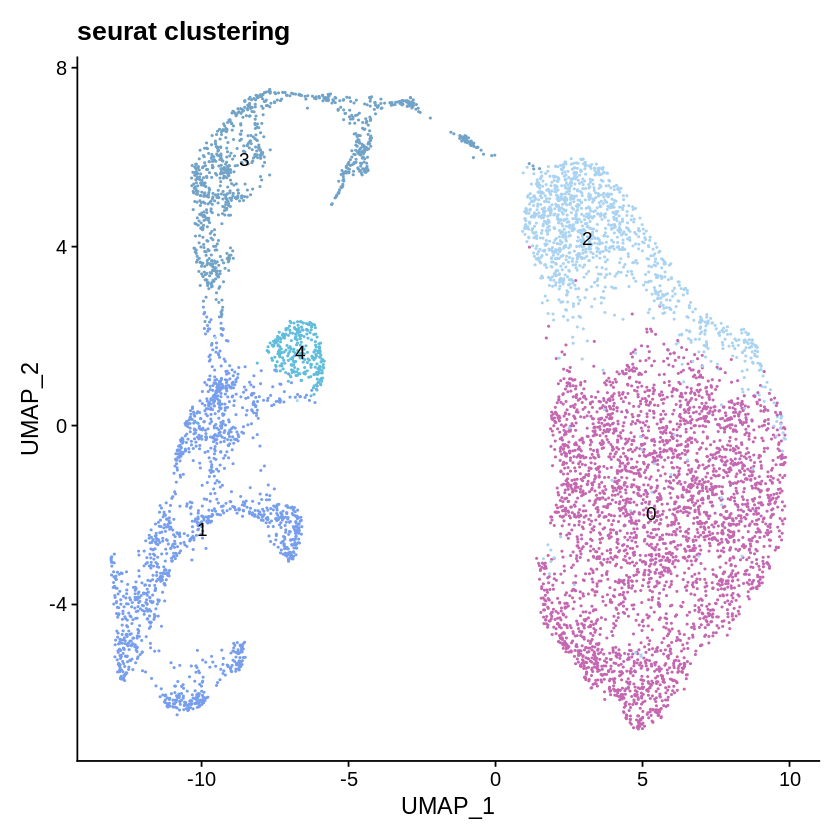

In [81]:
# Visualize
p1 = DimPlot(anndata, reduction = "umap", label = T, cols = colors) + ggtitle('seurat clustering') + NoLegend()
p1
ggsave(filename = paste0('clean_umap_clustering.pdf'), dpi = 75)

In [82]:
# Add metadata
anndata@meta.data$clusters_old = 'new'
anndata@meta.data$clusters_old[ rownames(anndata@meta.data) %in% meta_sup$X ] = 
meta_sup$annotated_clusters[ match(rownames(anndata@meta.data)[rownames(anndata@meta.data) %in% meta_sup$X], meta_sup$X) ]


Saving 13.3 x 13.3 in image



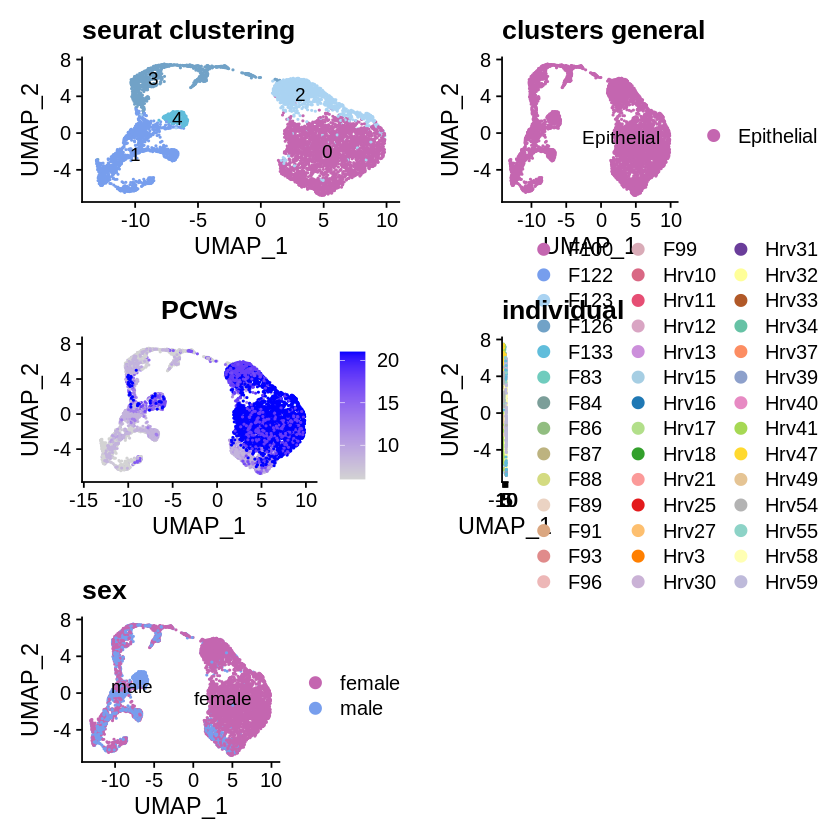

In [83]:
p1b = DimPlot(anndata, reduction = "umap", group.by = 'clusters_old', label = T, cols = colors) + ggtitle('clusters_old')
p2 = DimPlot(anndata, reduction = "umap", group.by = 'clusters', label = T, cols = colors) + ggtitle('clusters general')
p3 = FeaturePlot(anndata, reduction = "umap", 'PCW') + ggtitle('PCWs')
p4 = DimPlot(anndata, reduction = "umap", group.by = 'individual', cols = colors) + ggtitle('individual')
p5 = DimPlot(anndata, reduction = "umap", group.by = 'sex',  label = T, cols = colors) + ggtitle('sex')
plot_grid(p1, p2, p3, p4, p5, ncol = 2)
ggsave(filename = paste0('figures-epithelial/umap_metadata.pdf'), scale = 2, dpi = 75)

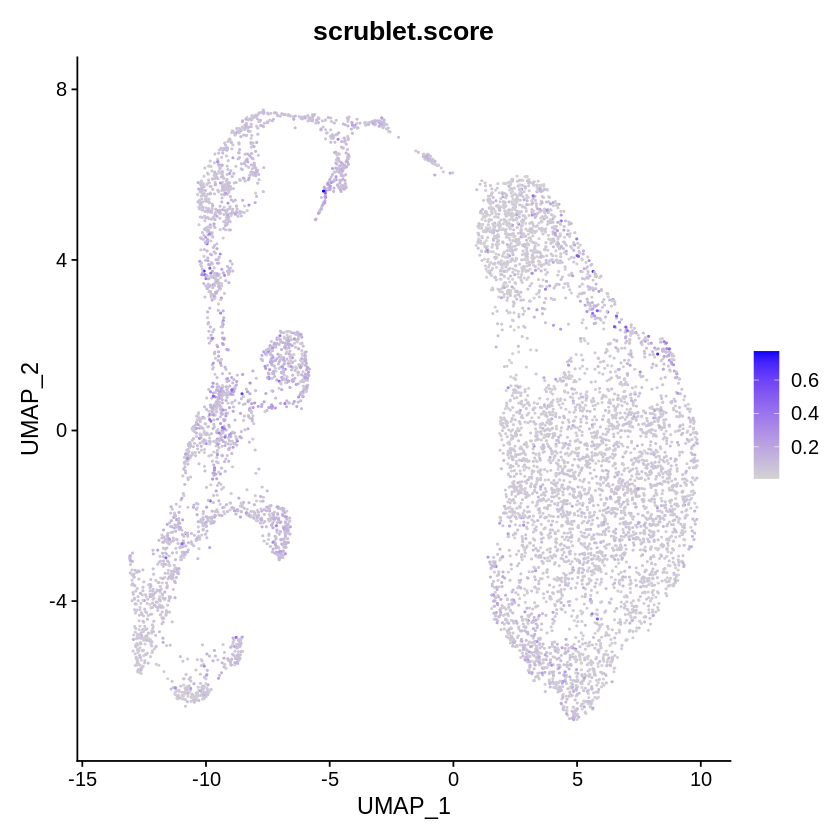

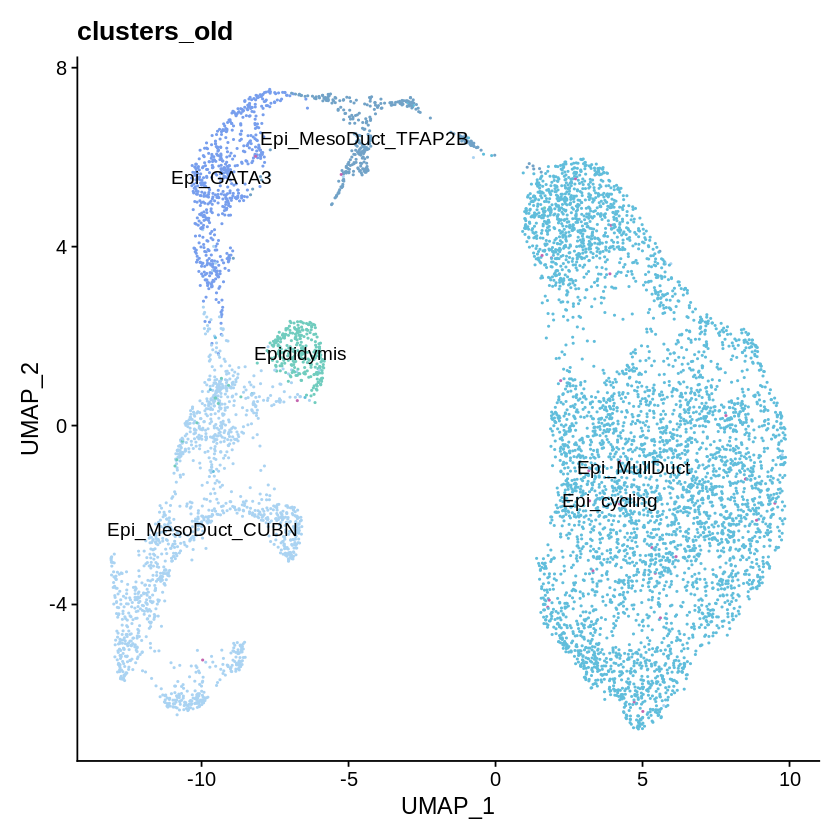

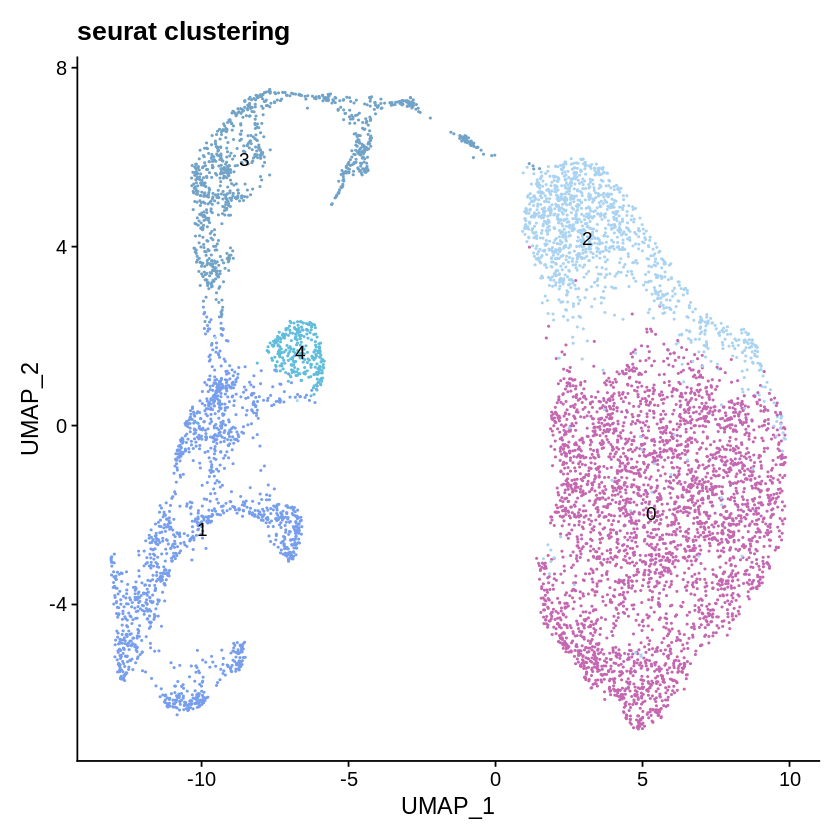

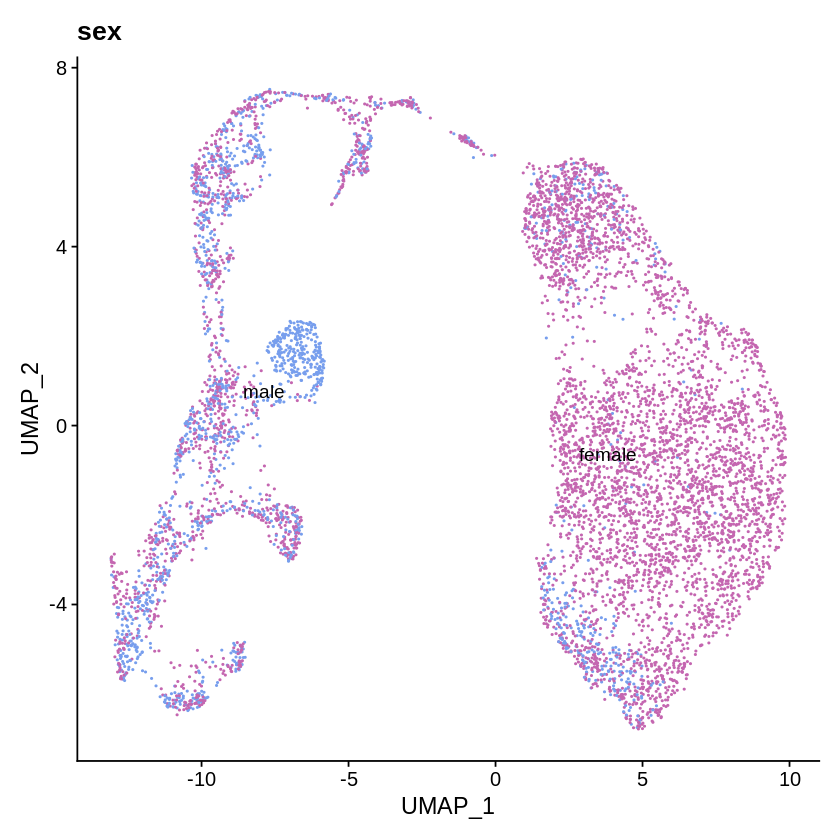

In [84]:
FeaturePlot(anndata, reduction = "umap", 'scrublet.score') + ggtitle('scrublet.score')
p1b + NoLegend()
p1
p5 + NoLegend()

Warning message in FetchData(object = object, vars = features, cells = cells):
“The following requested variables were not found: MYF5, PAX7”


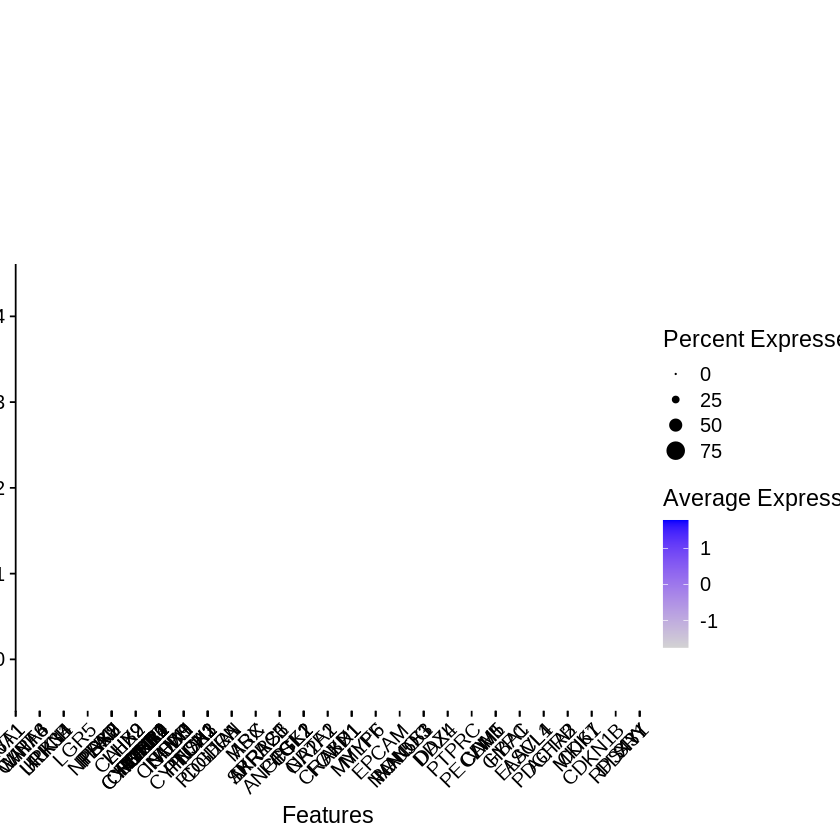

In [85]:
DotPlot(anndataO, features = markers, group.by = 'seurat_clusters') + RotatedAxis() + theme(strip.text.x = element_text(angle=90, hjust=0),
                                                                                            strip.background = element_rect(fill="#e8eced"))
ggsave(filename = paste0('clean_dotplot_markers.pdf'), dpi = 75, height = 7, width = 30)

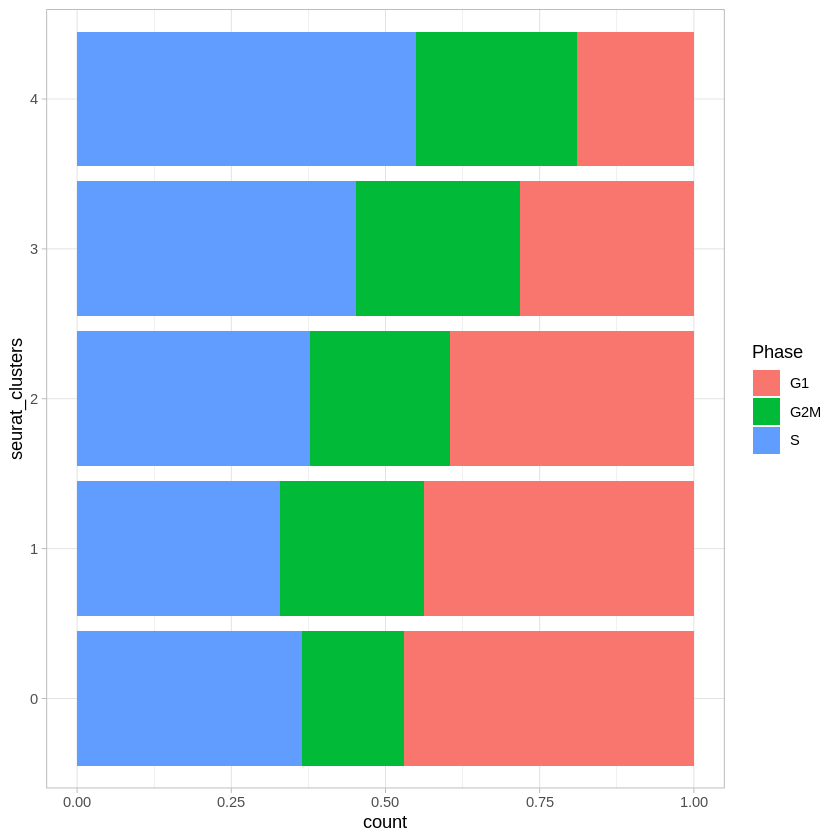

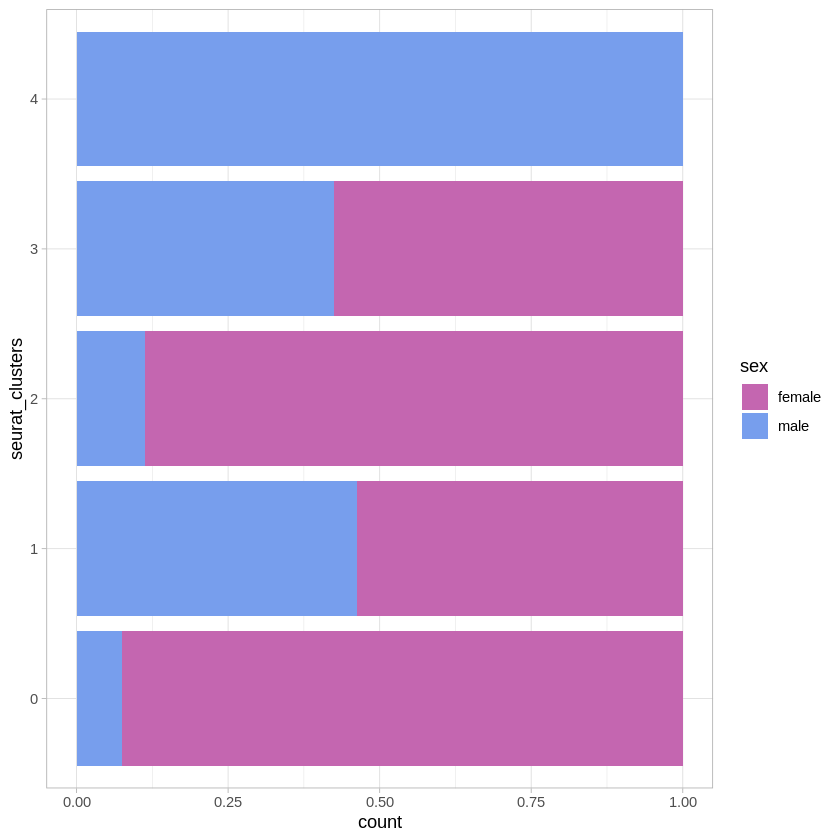

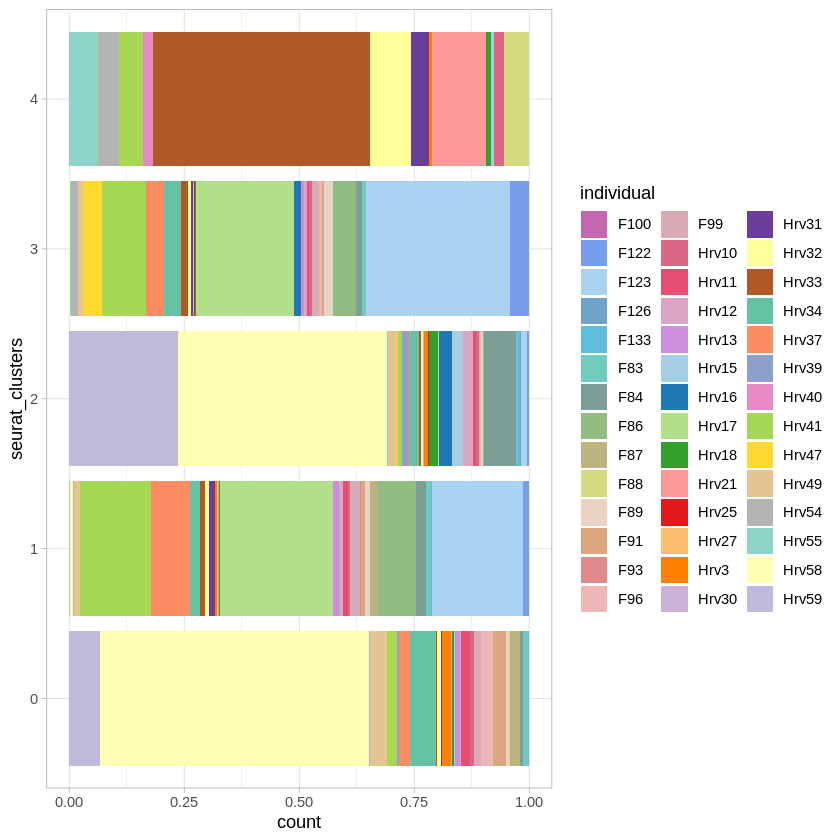

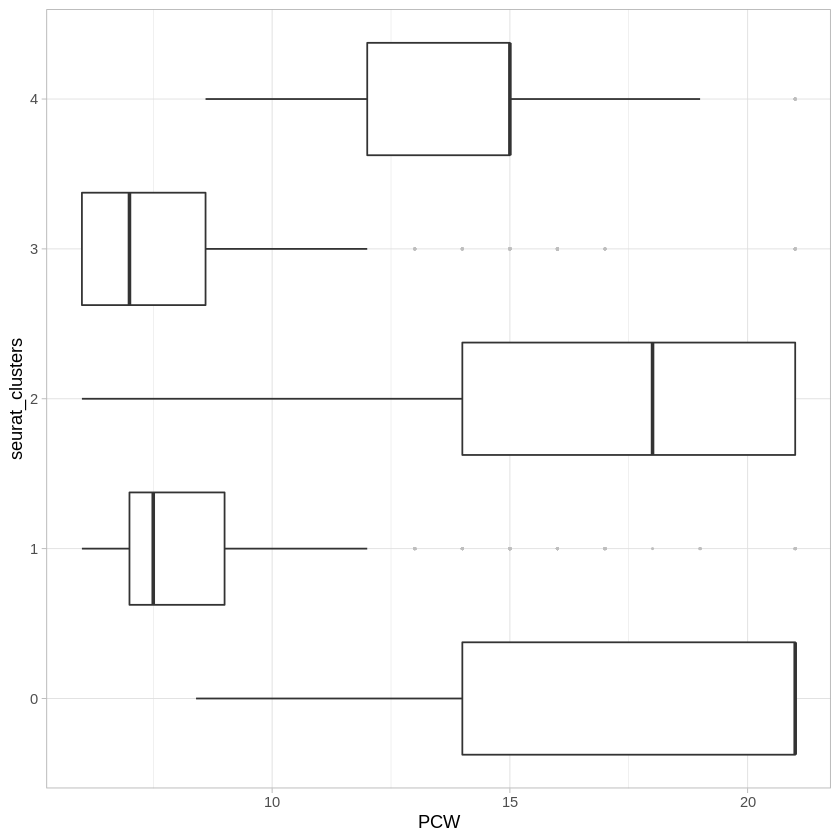

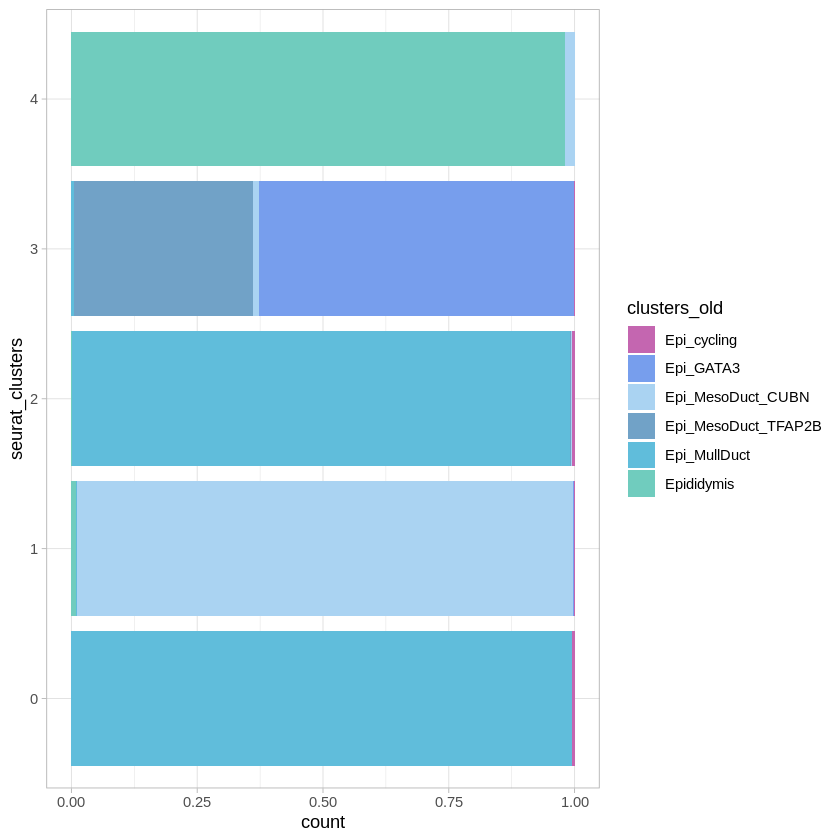

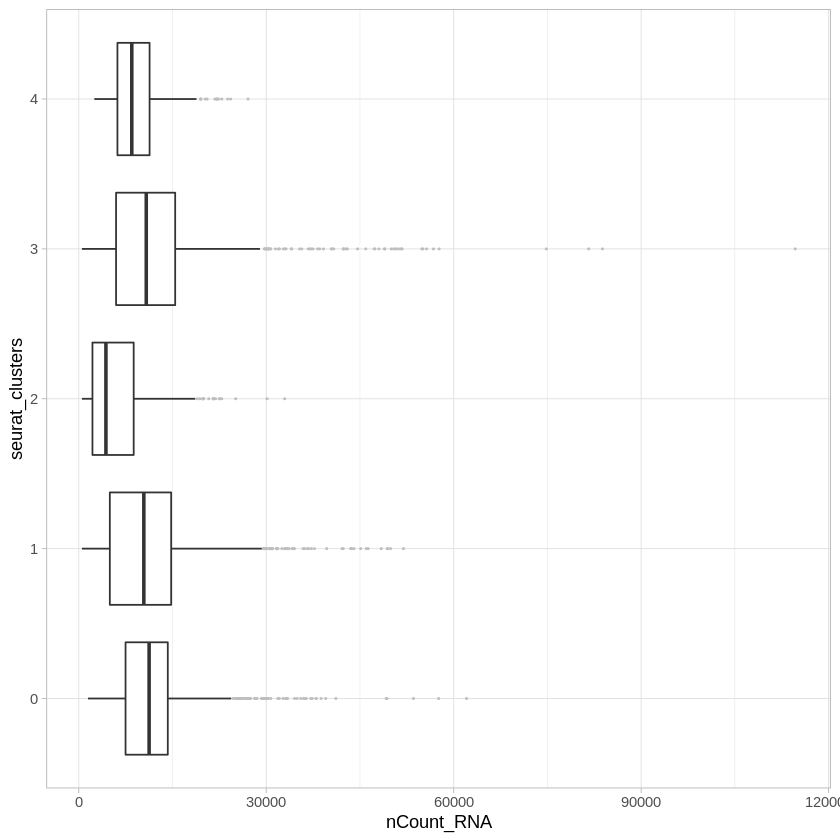

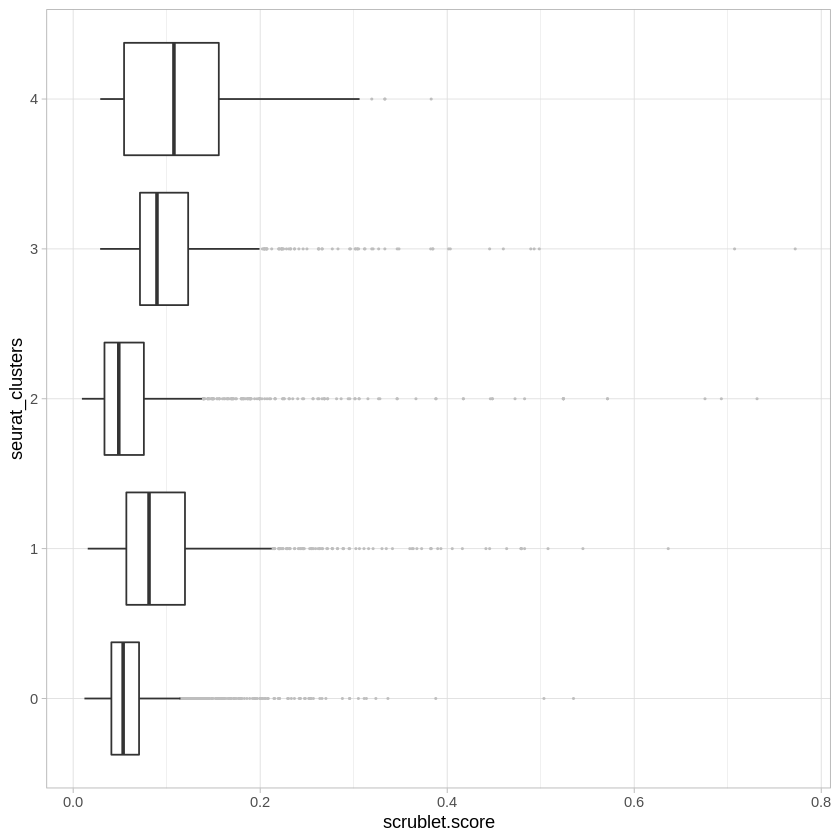

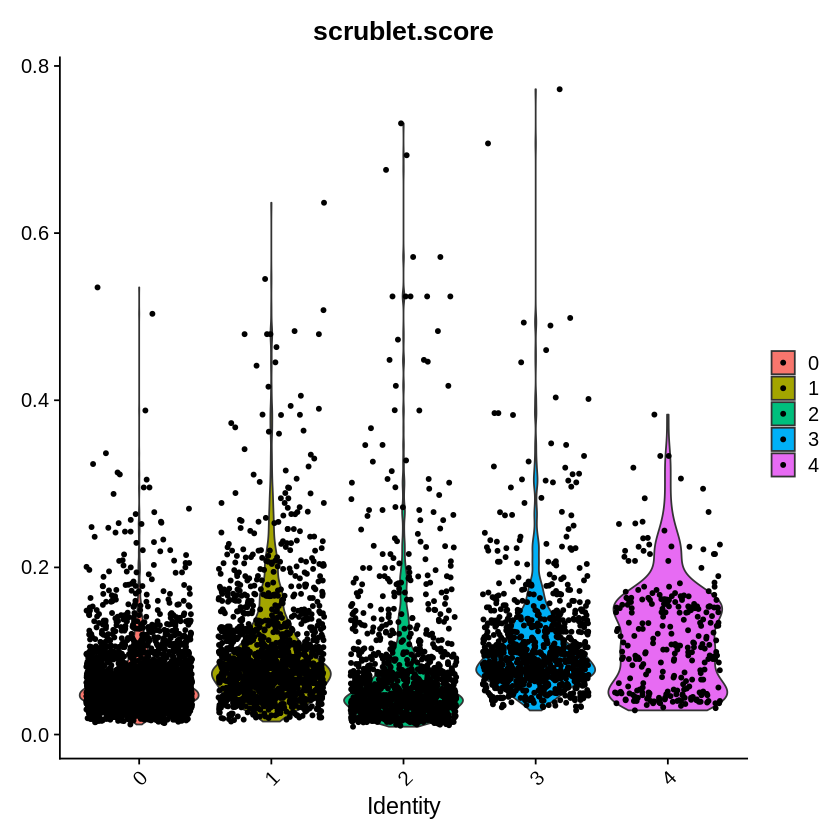

In [86]:
ggplot(anndata@meta.data, aes(x = seurat_clusters, fill = Phase)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    theme_light()

ggplot(anndata@meta.data, aes(x = seurat_clusters, fill = sex)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()


ggplot(anndata@meta.data, aes(x = seurat_clusters, fill = individual)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()



ggplot(anndata@meta.data, aes(x = seurat_clusters, y = PCW)) + 
    geom_boxplot(outlier.colour =  'grey', outlier.size = 0.2) + 
    coord_flip() +
    theme_light()


ggplot(anndata@meta.data, aes(x = seurat_clusters , fill = clusters_old )) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()

ggplot(anndataO@meta.data, aes(x = seurat_clusters, y = nCount_RNA)) + 
    geom_boxplot(outlier.colour =  'grey', outlier.size = 0.2) + 
    coord_flip() +
    theme_light()
ggplot(anndata@meta.data, aes(x = seurat_clusters, y = scrublet.score)) + 
    geom_boxplot(outlier.colour =  'grey', outlier.size = 0.2) + 
    coord_flip() +
    theme_light()

VlnPlot(anndata, 'scrublet.score')

### DEGs and GSA

In [87]:
df_tfIDF = quickMarkers(toc = anndataO@assays$RNA@counts, clusters = Idents(anndataO), N = 20)
dim(df_tfIDF)
# write.csv(df_tfIDF, file = 'clean_cluster_markersTFIDF.csv', quote = F, row.names = F)

[1] 100  10

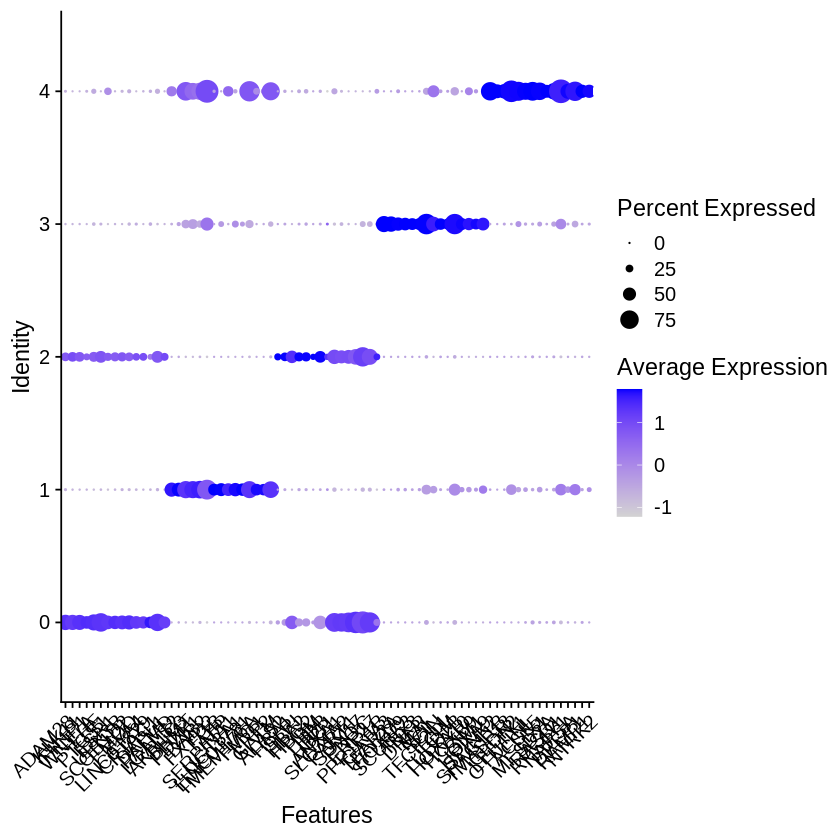

In [88]:
df_tfIDF$cluster = as.numeric(df_tfIDF$cluster)
df_tfIDF = df_tfIDF[ order(df_tfIDF$cluster), ]
DEGs_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 15L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF), group.by = 'seurat_clusters') + RotatedAxis()
ggsave(filename = paste0('clean_dotplot_TFIDF_DEGs.pdf'), dpi = 75, height = 5, width = 45)

# Annotate clusters

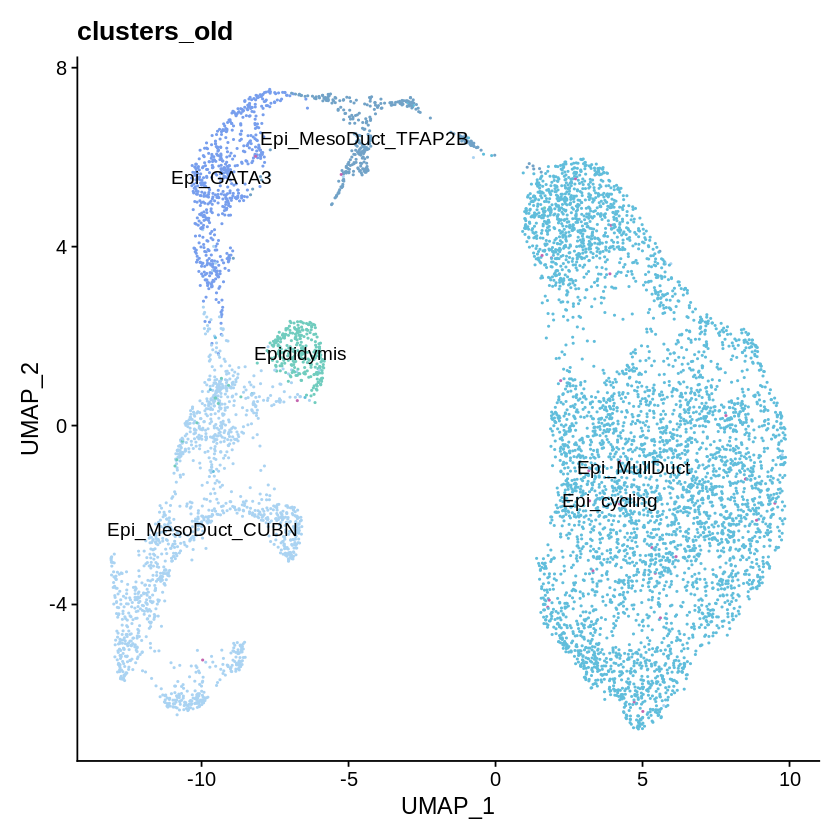

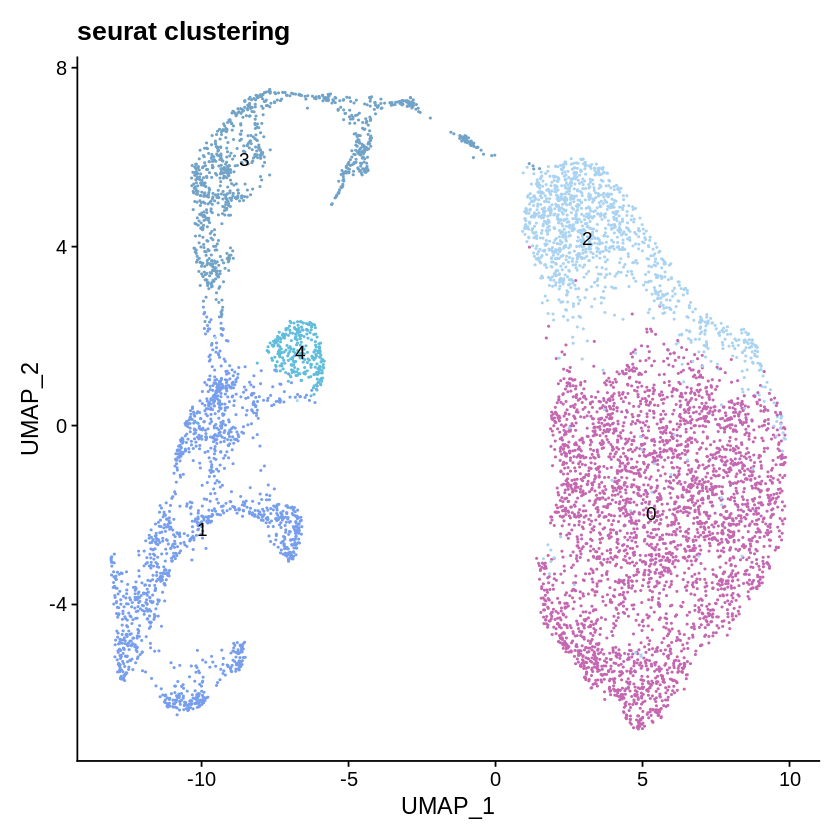

In [89]:
p1b + NoLegend()
p1

In [91]:
cluster_names = c('MullDuct',#0
                 'Mesoduct_CUBN',
                 'MullDuct',
                 'Mesoduct_GATA3',
                 'Epididymis'
)



anndata@meta.data$annotated_clusters = cluster_names[ match(anndata@meta.data$seurat_clusters, 
                                                            as.numeric(levels(anndata@meta.data$seurat_clusters)) ) ]


anndata@meta.data$annotated_clusters = factor(anndata@meta.data$annotated_clusters, levels = unique(sort(cluster_names)))

Idents(anndata) = anndata@meta.data$annotated_clusters
anndataO@meta.data$annotated_clusters = anndata@meta.data$annotated_clusters
Idents(anndataO) = anndataO@meta.data$annotated_clusters

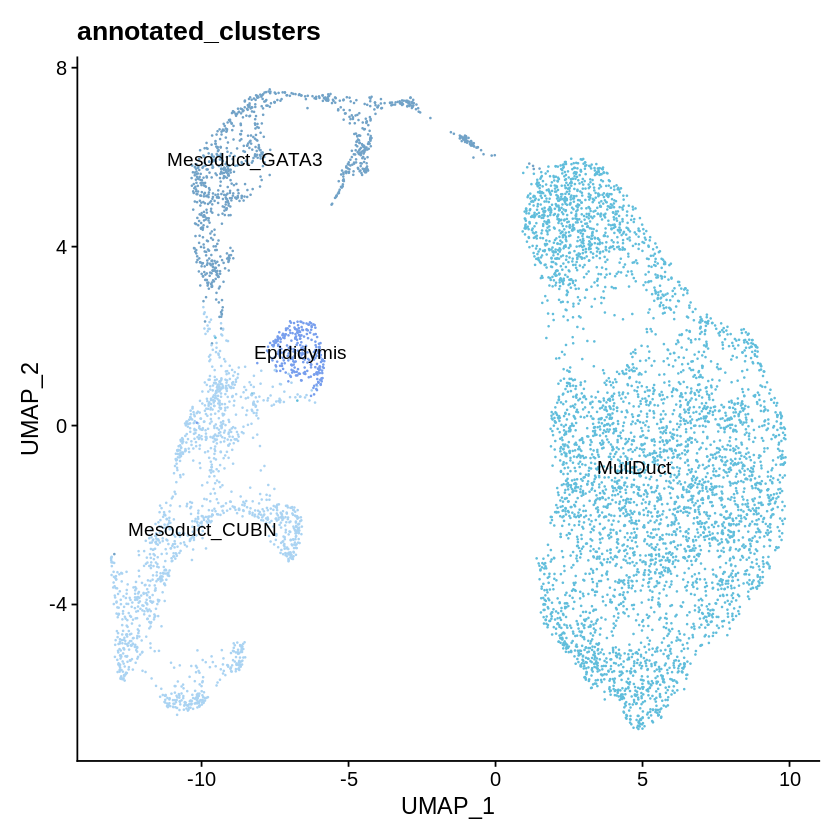

In [92]:
p1b = DimPlot(anndata, reduction = "umap", group.by = 'annotated_clusters', label = T, pt.size = 0.1,
             cols = colors[-1] ) + ggtitle('annotated_clusters')
p1b+ NoLegend()
ggsave(filename = paste0('clean_umap_annotated.pdf'), dpi = 75, width = 7, height = 7)

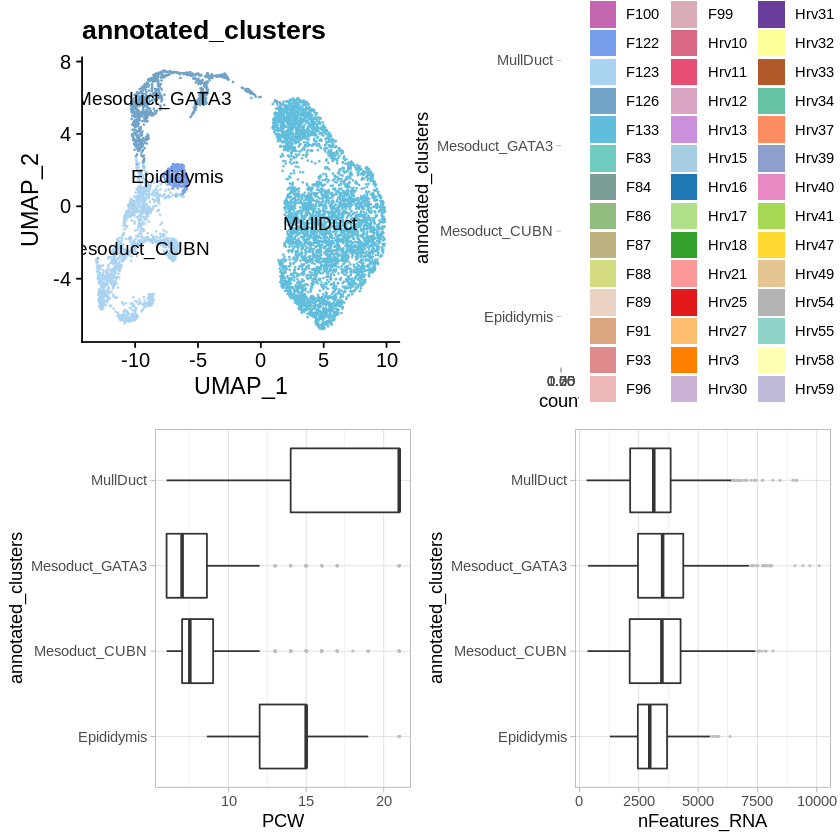

In [93]:
b1 = ggplot(anndata@meta.data, aes(x = annotated_clusters, fill = individual)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()

b2 = ggplot(anndata@meta.data, aes(x = annotated_clusters, y = PCW)) + 
    geom_boxplot(outlier.colour =  'grey', outlier.size = 0.2) + 
    coord_flip() +
    theme_light()
b3 = ggplot(anndata@meta.data, aes(x = annotated_clusters, y = nFeatures_RNA)) + 
    geom_boxplot(outlier.colour =  'grey', outlier.size = 0.2) + 
    coord_flip() +
    theme_light()
plot_grid(p1b+NoLegend(), b1, b2, b3, ncol = 2)
ggsave(filename = paste0('clean_metadata_annotated.pdf'), dpi = 75, width = 10, height = 10)

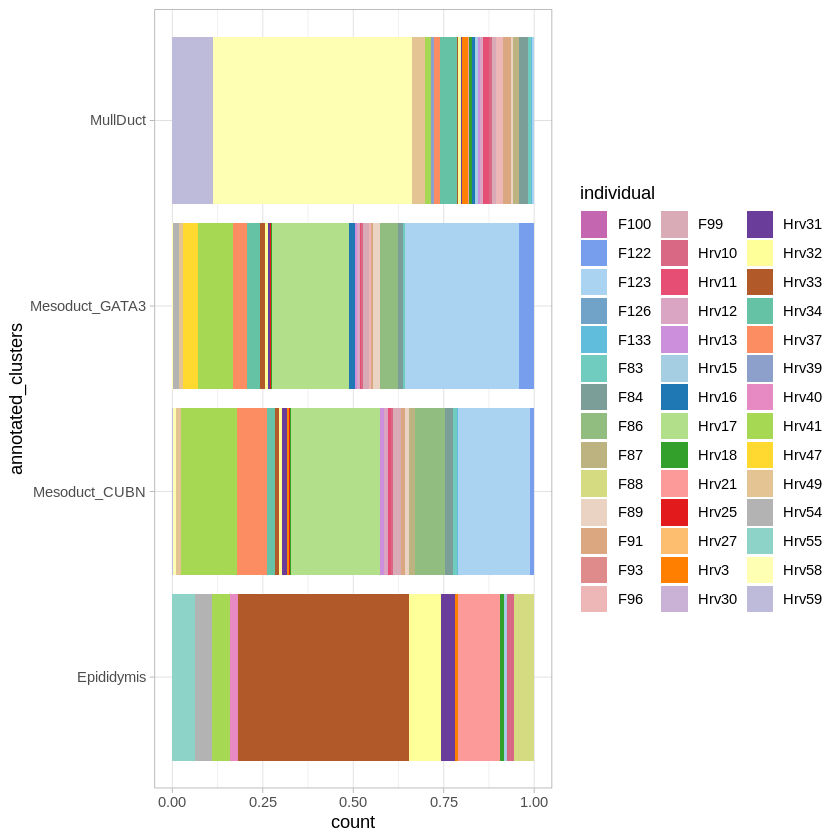

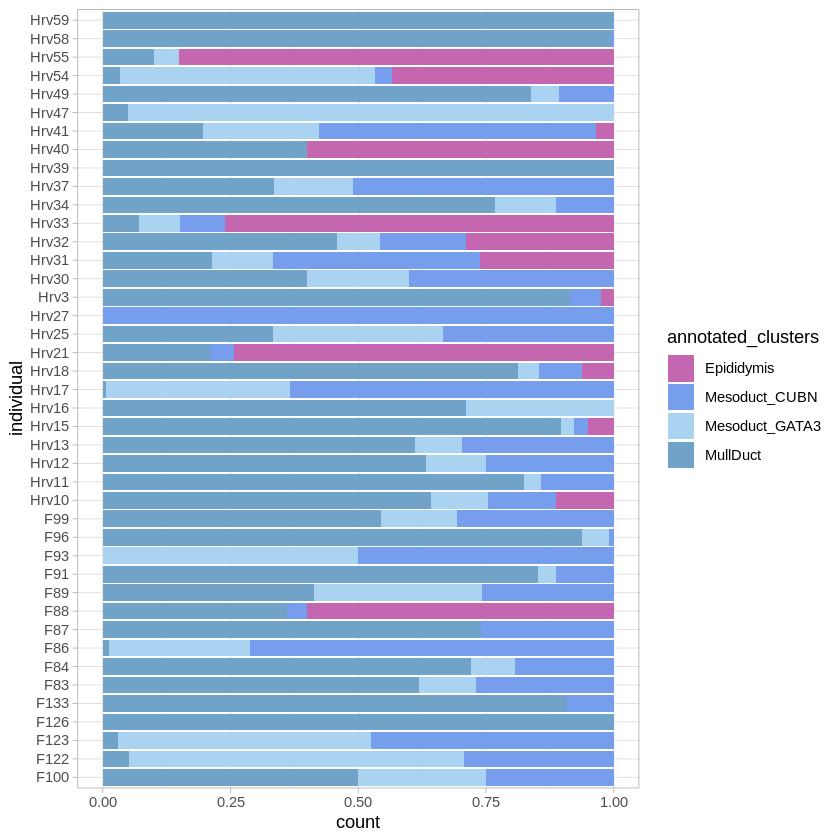

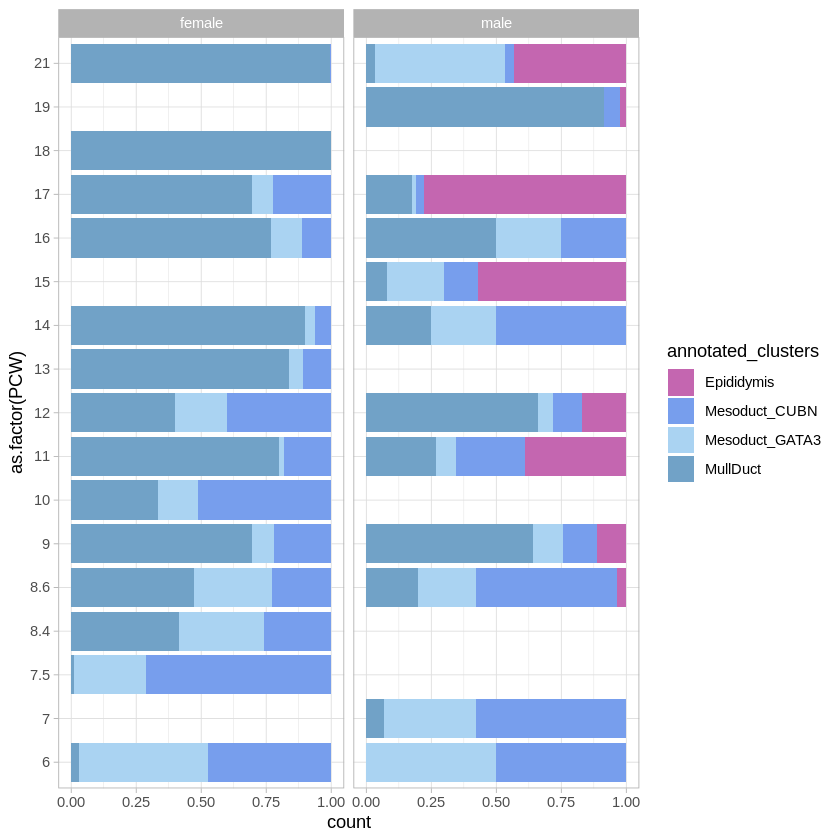

In [94]:
ggplot(anndata@meta.data, aes(x = annotated_clusters, fill = individual)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()
ggplot(anndata@meta.data, aes(x = individual , fill = annotated_clusters)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()
ggplot(anndata@meta.data, aes(x = as.factor(PCW) , fill = annotated_clusters)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +  facet_wrap(~sex) +
    scale_fill_manual(values = colors) + theme_light()

# Markers

In [95]:
df_tfIDF = quickMarkers(toc = anndataO@assays$RNA@counts, clusters = Idents(anndataO), N = 100)
dim(df_tfIDF)
# write.csv(df_tfIDF, file = 'clean_cluster_markersTFIDF_annotated.csv', quote = F, row.names = F)

[1] 400  10

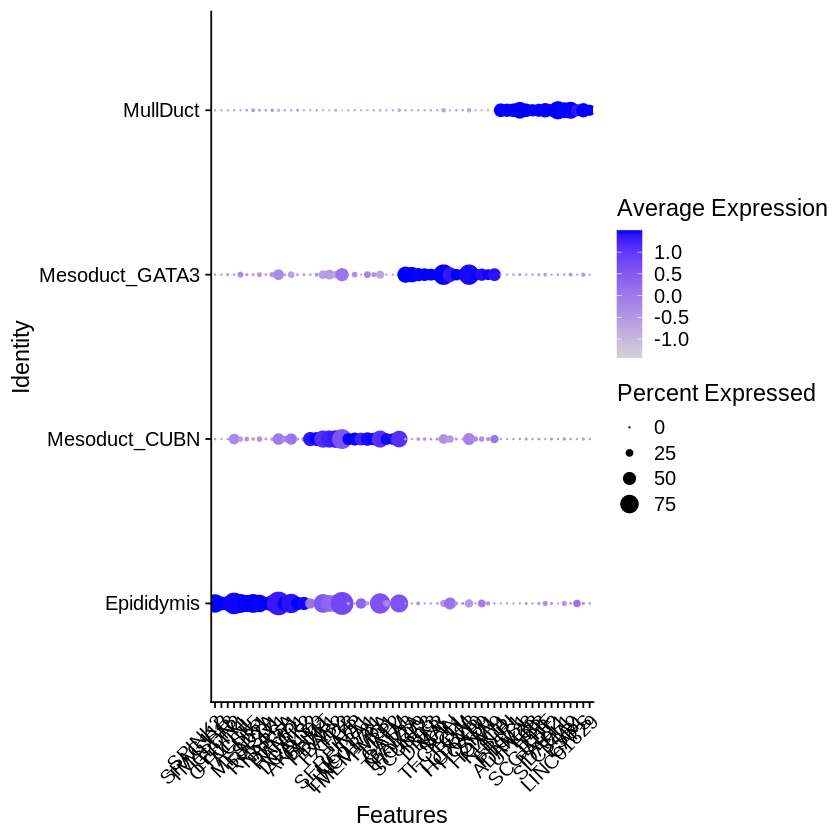

In [96]:
df_tfIDF$cluster = factor(df_tfIDF$cluster, levels = levels(anndataO@meta.data$annotated_clusters) )
DEGs_tfIDF = subset(df_tfIDF, qval <= 0.01) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 15L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF)) + RotatedAxis()
ggsave(filename = paste0('clean_dotplot_TFIDF_DEGs_annotated.pdf'), dpi = 75, height = 5, width = 45)

Warning message in FetchData(object = object, vars = features, cells = cells):
“The following requested variables were not found: MYF5, PAX7”


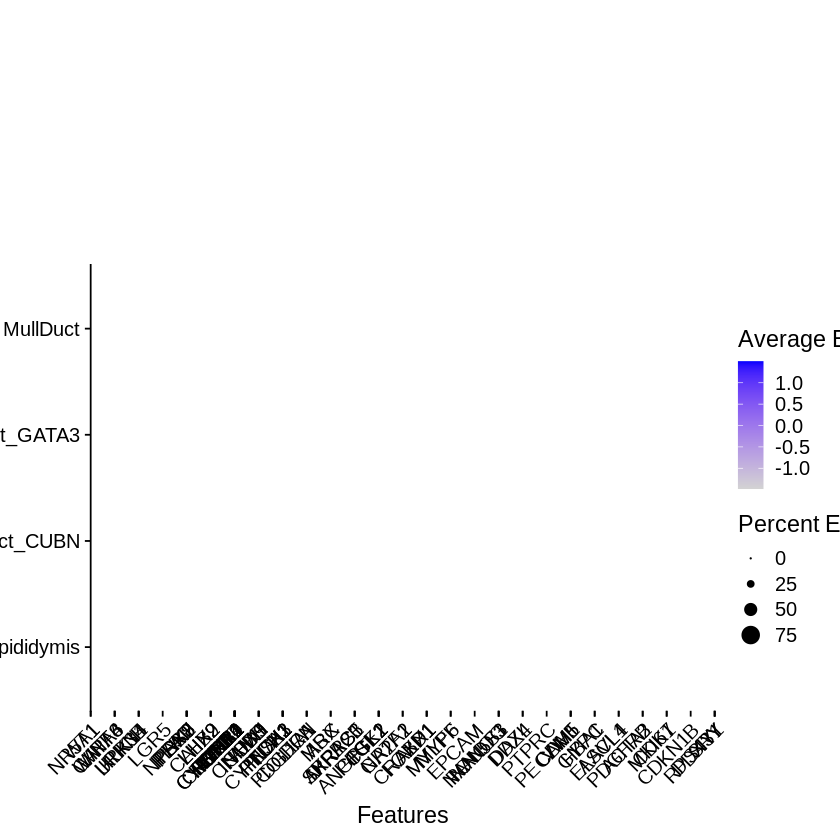

In [97]:
DotPlot(anndataO, features = markers, group.by = 'annotated_clusters') + RotatedAxis() + theme(strip.text.x = element_text(angle=90, hjust=0),
                                                                                            strip.background = element_rect(fill="#e8eced"))
ggsave(filename = paste0('clean_dotplot_markers_annotated.pdf'), dpi = 75, height = 7, width = 25)

In [99]:
write.csv(anndata@meta.data, file = paste0('clean_annotation.csv'), quote = F, row.names = T)
write.csv(anndata@meta.data, file = '/nfs/team292/lg18/with_valentina/epithelial_annotation.csv', quote = F, row.names = T)
saveRDS(anndataO, file = '/nfs/team292/lg18/with_valentina/epithelial.rds')